# Testing the Linear Model trained in TensorFlow 

In [1]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [56]:
goal = np.array([[0], [0], [1], [0], [2], [0]])
args = {'checkpoint': "log_data/random_50_fixed_AB/December_06_18:54:11__120b146dae/nn.ckpt-250", 'log': False, 'batch_size': 1000}
dataset = "../../../link_bot_teleop/data/random_50_steps.txt"
test_x_data = tpo.load_train(dataset, n_steps=50, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))
print(test_x_data.shape)

(51, 8, 250)


In [57]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)
DT = 0.1

In [4]:
model = LinearTFModel(args, N=6, M=2, L=2, n_steps=1, dt=DT)
model.load()

INFO:tensorflow:Restoring parameters from log_data/random_50_fixed_AB/December_06_18:54:11__120b146dae/nn.ckpt-250
Restored ckpt log_data/random_50_fixed_AB/December_06_18:54:11__120b146dae/nn.ckpt-250 at step 250


## This is the best linear model I was able to train

In [5]:
A, B, C, D, c_loss, sp_loss, cp_loss, reg, loss = model.evaluate(test_x_data, goal, display=True)

Cost Loss: 0.424724549055
State Prediction Loss: 0.149557992816
Cost Prediction Loss: 9.6110534668
Regularization: 2.46370692736e-08
Overall Loss: 10.185336113
A:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
B:
[[0. 0.]
 [0. 0.]]
C:
[[ 0.71  0.06]
 [-0.08  0.6 ]]
D:
[[ 1.05 -0.01]
 [-0.01  0.97]]


## Plot the cost of each x,y around the goal

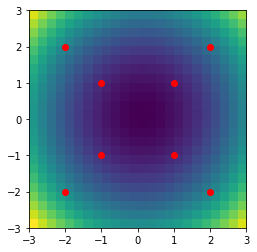

In [6]:
tpo.plot_costmap_2(plt, model, data, goal, resolution=.25, minimum=-3, maximum=3)
plt.scatter([1, 1, -1, -1], [1, -1, 1, -1], color='r')
plt.scatter([2, 2, -2, -2], [2, -2, 2, -2], color='r');

## Verify numerically that the parabaloid is not skewed

In other words, the direction of steepest descent is the same as the direction of the goal

In [7]:
def cost_at_xy(x, y):
    s = np.array([[x], [y], [0], [0], [0], [0]])
    print(model.cost_of_s(s, goal)[0,0])
    
print("Example 1:")
cost_at_xy(1, 1)
cost_at_xy(-1, 1)
cost_at_xy(-1, -1)
cost_at_xy(1, -1)
print("\nExample 2:")
cost_at_xy(2, 2)
cost_at_xy(-2, 2)
cost_at_xy(-2, -2)
cost_at_xy(2, -2)

Example 1:
1.9977229
2.0534346
1.9977229
2.0534346

Example 2:
7.9908915
8.213738
7.9908915
8.213738


## Zoom in and plot arrows showing the direction of the "best action" 

In [48]:
def policy_quiver(ax, cx, cy, r, m, scale=10):
    x = []
    y = []
    u = []
    v = []
    og = model.reduce(goal)
    for s1 in np.arange(cx-m, cx+m+r, r):
        for s2 in np.arange(cy-m, cy+m+r, r):
            o = model.reduce(np.array([[s1], [s2], [0], [0], [0], [0]]))
            o1 = o[0, 0]
            o2 = o[1, 0]
            a, c, next_o = model.act(o, goal, max_v=2)
            x.append(s1)
            y.append(s2)
            u.append(a[0, 0, 0])
            v.append(a[0, 1, 0])
    q = ax.quiver(x, y, u, v, scale=scale, width=scale/20000.0)

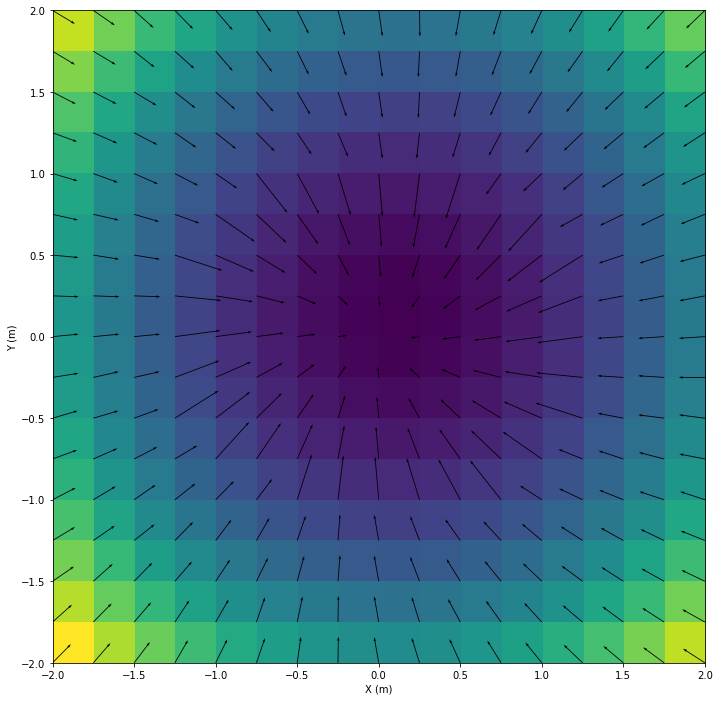

In [50]:
plt.figure(figsize=(12,12))
tpo.plot_costmap_2(plt, model, data, goal, resolution=0.25, minimum=-2, maximum=2)
ax = plt.gca()
policy_quiver(ax, 0, 0, 0.25, 2, scale=25)
plt.xlabel("X (m)")
plt.ylabel("Y (m)");

'best' u at (1,1) = [[-0.72 -0.69]]
initial o: [[1. 1.]]
predicted o after action: [[0.94 0.96]]
initial cost:  [[2.]]
predicted cost after action:  [1.82]
cost of predicted s:  [[1.82]]
cost of my s: [[1.92]]
o of my s (reduced): [[0.98 0.98]]
dist from o to my o: 0.028284244
dist from o to 'best' o: 0.065918356
u that goes from o to my o: [[-0.03 -0.04]]
magnitude of 'best' u: 1.0
magnitude of my u: 0.044405933


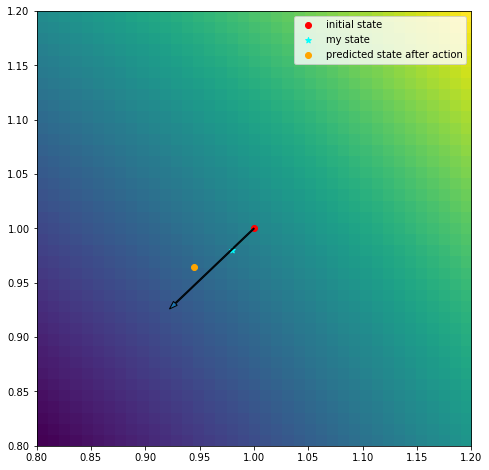

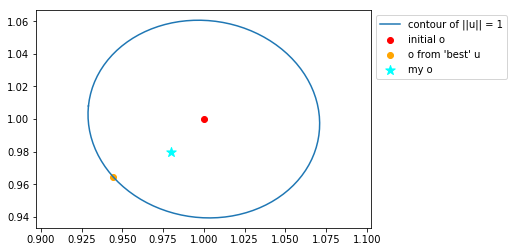

In [10]:
# what doest act tell us to do, and where does it take us?
x = 1
y = 1
s = np.array([[x], [y], [0], [0], [0], [0]])
o = model.reduce(s)
best_u, c_from_best_u, o_from_best_u = model.act(o, goal)
s_back = np.dot(np.linalg.pinv(A), o_from_best_u)
print("'best' u at ({},{}) = {}".format(x, y, best_u[0].T))
print("initial o:", o.T)
print("predicted o after action:", o_from_best_u.T)
print("initial cost: ", model.cost(o, goal))
print("predicted cost after action: ", c_from_best_u)
print("cost of predicted s: ", model.cost_of_s(s_back, goal))

## But I can find a u that gives me a better next cost
d = 0.02 # 0.027994
my_x = x-d
my_y = y-d
my_s = np.array([[my_x], [my_y], [0], [0], [0], [0]])
my_o = model.reduce(my_s)
# my_u = np.dot(np.linalg.pinv(C), (my_o - o - np.dot(B, o)))
my_u = np.linalg.lstsq(C, my_o - o - np.dot(B, o), rcond=None)[0]
print("cost of my s:", model.cost_of_s(my_s, goal))
print("o of my s (reduced):", my_o.T)
print("dist from o to my o:", np.linalg.norm(my_o - o))
print("dist from o to 'best' o:", np.linalg.norm(o_from_best_u - o))
print("u that goes from o to my o:", my_u.T)
print("magnitude of 'best' u:", np.linalg.norm(best_u))
print("magnitude of my u:", np.linalg.norm(my_u))

o1_from_fixed_u = []
o2_from_fixed_u = []
for angle in np.linspace(-np.pi, np.pi, 100):
    test_u = np.array([[[np.cos(angle)], [np.sin(angle)]]])
    test_o = model.predict(o, test_u)
    o1_from_fixed_u.append(test_o[0,0])
    o2_from_fixed_u.append(test_o[1,0])

plt.figure(figsize=(8,8))
tpo.plot_costmap_2(plt, model, data, goal, resolution=.01, minimum=0.8, maximum=1.2)
plt.scatter(x, y, color='red', label='initial state')
plt.scatter(my_x, my_y, color='cyan', marker='*', label='my state')
plt.scatter(s_back[0,0], s_back[1,0], color='orange', label='predicted state after action')
plt.arrow(x, y, best_u[0,0,0]*0.1, best_u[0,1,0]*0.1, head_width=0.005)
plt.legend()

plt.figure()
plt.scatter(o[0,0], o[1,0], label='initial o', color='red')
plt.scatter(o_from_best_u[0,0], o_from_best_u[1,0], color='orange', label="o from 'best' u")
plt.scatter(my_o[0,0], my_o[1,0], label='my o', color='cyan', marker='*', s=100)
plt.plot(o1_from_fixed_u, o2_from_fixed_u, label='contour of ||u|| = 1')
plt.axis("equal")
plt.legend(bbox_to_anchor=(1,1));

### The reason that the elipse is off-center is because my B matrix is not exactly zero

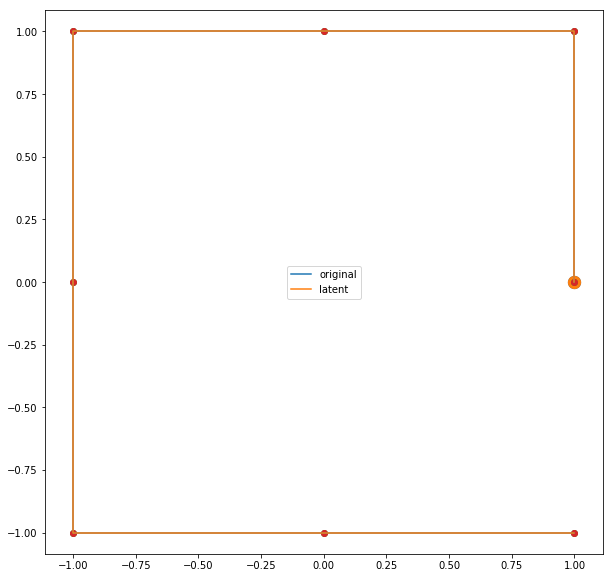

In [13]:
points = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.get_A()[:,:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal");

In [53]:
x = 2
y = -2
o = model.reduce(np.array([[x], [y], [x], [y], [x], [y]]))
o1 = o[0, 0]
o2 = o[1, 0]
M = 10
u, _, _ = model.act(o, goal)
u = u / np.linalg.norm(u) * M
print("Newton Step:", u[0].T)
print("Newton Step Cost:", model.predict_cost(o, u, goal)[0,0])
min_cost = 1e9
min_cost_u = None
costs = []
angles = np.linspace(-np.pi, np.pi, 100)
for angle in angles:
    u = np.array([[[np.cos(angle)], [np.sin(angle)]]]) * M
    cost = model.predict_cost(o, u, goal)[0, 0]
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        min_cost_u = u;
print("Steepest-Descent: ", min_cost_u[0].T)
print("Steepest-Descent Cost: ", min_cost)

Newton Step: [[-8.41  5.41]]
Newton Step Cost: 4.7538443
Steepest-Descent:  [[-8.05  5.93]]
Steepest-Descent Cost:  4.752919
